In [6]:
!pip install pandas
!pip install statsmodels


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Prédiction du cumul mensuel des durées d'insolation (en heures et 1/10)

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

dossier = './data/IN'

dfs = []

for fichier in os.listdir(dossier):
    if fichier.endswith('.csv'):
        chemin_fichier = os.path.join(dossier, fichier)
        df = pd.read_csv(chemin_fichier, delimiter=';', skiprows=11)
        dfs.append(df)

data_IN = pd.concat(dfs, ignore_index=True)
data_IN.head()
data_IN['YYYYMM'] = pd.to_datetime(data_IN['YYYYMM'], format='%Y%m')
pd.DataFrame(data_IN.groupby('YYYYMM').mean())
# data_IN.to_csv('./IN.csv', index=False)

,VALEUR,Q_HOM
YYYYMM,,
1931-01-01,76.470370,1.0
1931-02-01,88.218519,1.0
1931-03-01,153.333333,1.0
1931-04-01,166.425926,1.0
1931-05-01,206.933333,1.0
...,...,...
2014-08-01,206.388889,1.0
2014-09-01,227.244444,1.0
2014-10-01,160.762963,1.0


In [8]:
in_mean = data_IN.groupby('YYYYMM').mean()
in_mean_df = pd.DataFrame(in_mean)
in_mean_df

,VALEUR,Q_HOM
YYYYMM,,
1931-01-01,76.470370,1.0
1931-02-01,88.218519,1.0
1931-03-01,153.333333,1.0
1931-04-01,166.425926,1.0
1931-05-01,206.933333,1.0
...,...,...
2014-08-01,206.388889,1.0
2014-09-01,227.244444,1.0
2014-10-01,160.762963,1.0


In [9]:
in_mean_df = in_mean_df.reset_index()
in_mean_df

,YYYYMM,VALEUR,Q_HOM
0,1931-01-01,76.470370,1.0
1,1931-02-01,88.218519,1.0
2,1931-03-01,153.333333,1.0
3,1931-04-01,166.425926,1.0
4,1931-05-01,206.933333,1.0
...,...,...,...
1003,2014-08-01,206.388889,1.0
1004,2014-09-01,227.244444,1.0
1005,2014-10-01,160.762963,1.0
1006,2014-11-01,82.474074,1.0


In [10]:
multiplicative_decomposition_in = seasonal_decompose(in_mean_df['VALEUR'], model='multiplicative', period=12)

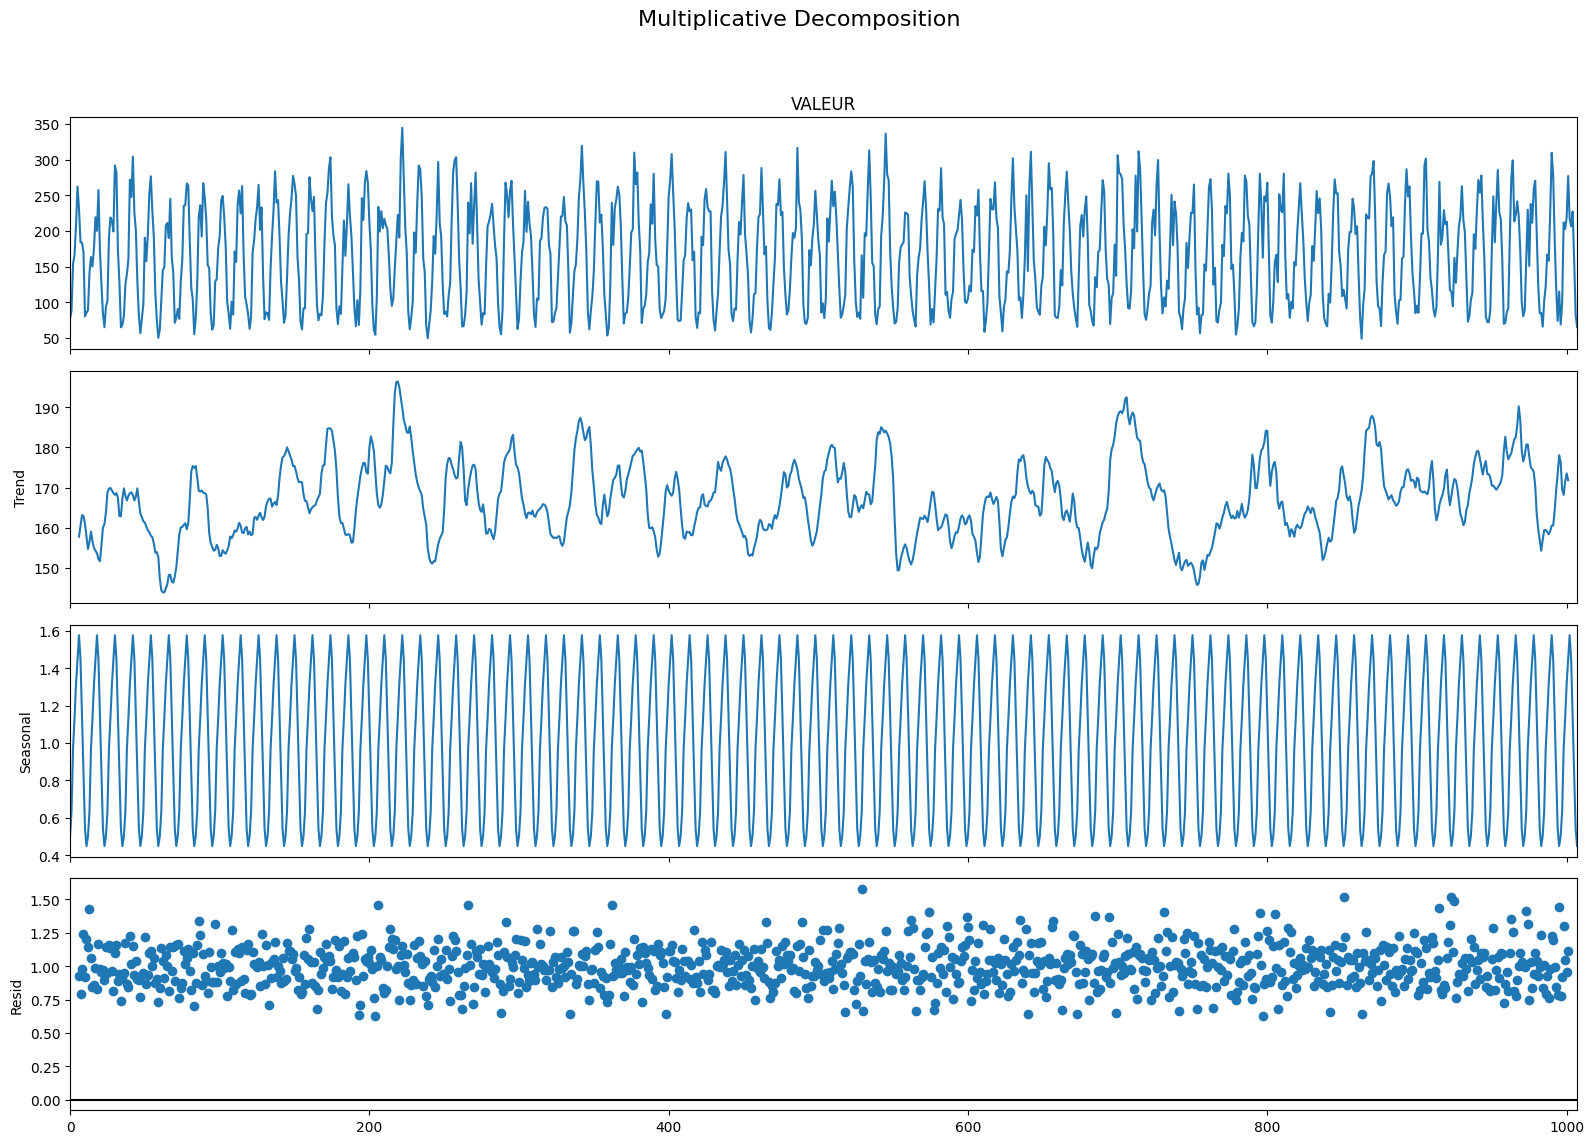

In [11]:
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition_in.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

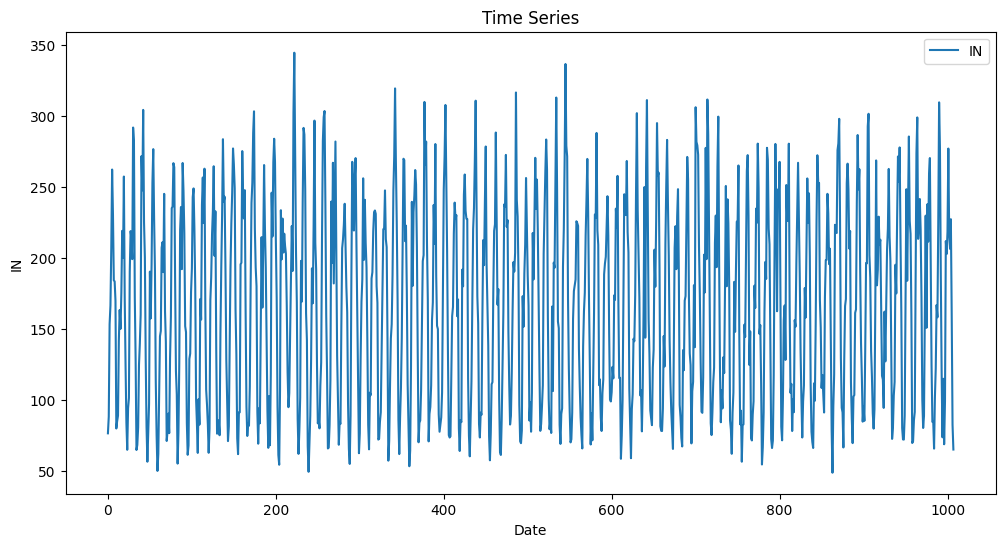

(-6.803494463306399,
 2.2065007072768146e-09,
 22,
 985,
 {'1%': -3.4370062675076807,
  '5%': -2.8644787205542492,
  '10%': -2.568334722615888},
 9434.280359146089)

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(in_mean_df['VALEUR'], label='IN')
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('IN')
plt.legend()
plt.show()

adf_in_test_result = adfuller(in_mean_df['VALEUR'])

adf_in_test_result

In [13]:
data_length = len(in_mean_df)
data_length

# Définir les indices pour diviser les données - 80% pour l'entraînement, 20% pour le test
train_size = int(data_length * 0.98)
test_size = data_length - train_size

# Préparer les séries d'apprentissage et de test
train_df = in_mean_df.iloc[:train_size]
test_df = in_mean_df.iloc[train_size:]

# Sélectionner la colonne 'RR' pour l'analyse
X_train = train_df['VALEUR']
X_test = test_df['VALEUR']

train_size, test_size

(987, 21)

c:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


27.800569542344643


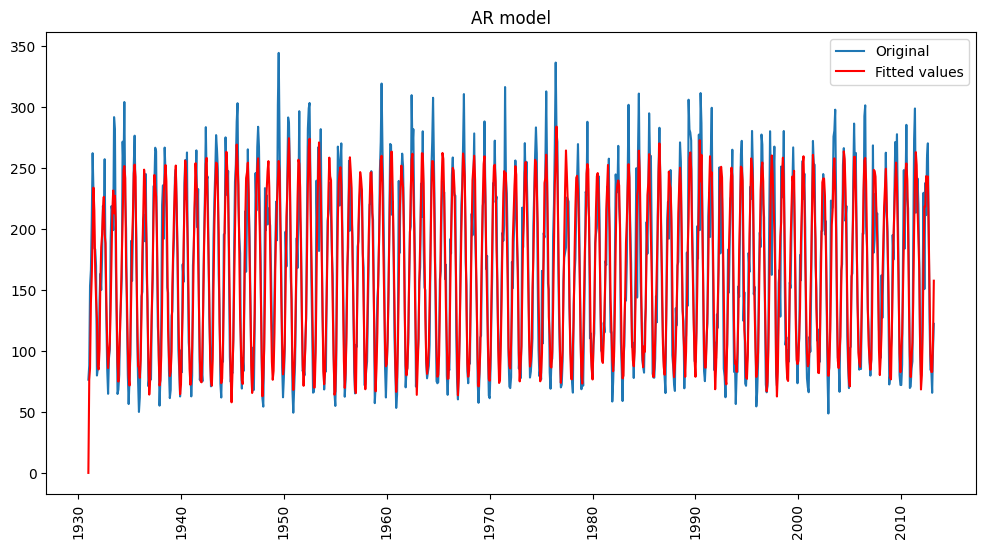

In [14]:
# Modèle ARIMA
model_ARIMA = ARIMA(X_train, order=(12, 1, 24))  
results_ARIMA = model_ARIMA.fit()

# Calculer le RMSE pour le modèle AR
rmse = sqrt(mean_squared_error(X_train, results_ARIMA.fittedvalues))
print(rmse)

plt.figure(figsize=(12, 6))
plt.plot(train_df['YYYYMM'], train_df['VALEUR'], label='Original')
plt.plot(train_df['YYYYMM'], results_ARIMA.fittedvalues, color='red', label='Fitted values')
plt.xticks(rotation=90)
plt.title('AR model')
plt.legend()
plt.show()


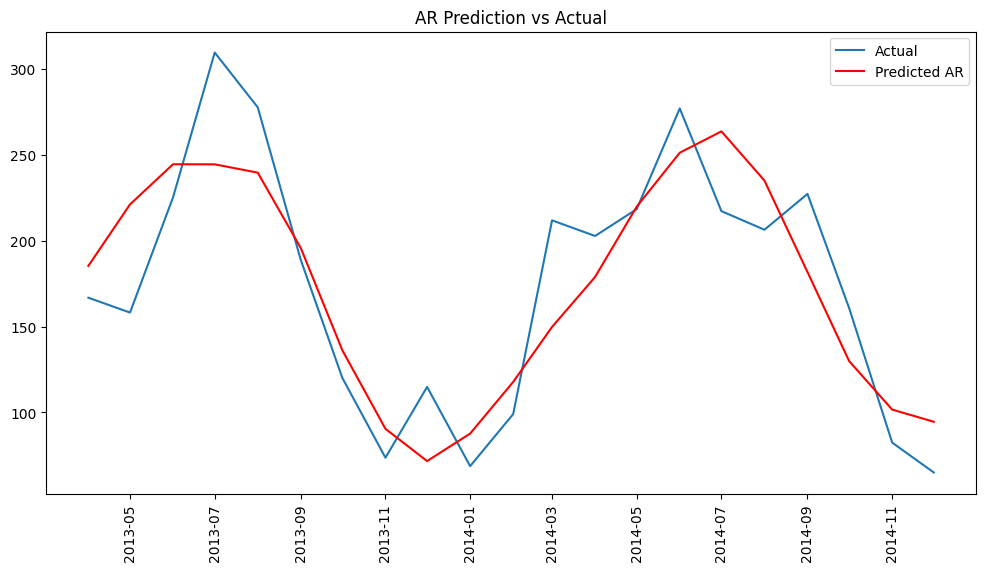

In [15]:
# Prédictions avec le modèle AR
predictions_AR = results_ARIMA.forecast(steps=test_size)

# Préparer la visualisation des prédictions AR vs valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(test_df['YYYYMM'], X_test, label='Actual')
plt.plot(test_df['YYYYMM'], predictions_AR, color='red', label='Predicted AR')
plt.xticks(rotation=90)
plt.title('AR Prediction vs Actual')
plt.legend()
plt.show()

## Prédiction du cumul mensuel des hauteurs de précipitation (en mm et 1/10)

In [19]:
dossier = './data/RR/'
dfs = []

for fichier in os.listdir(dossier):
    if fichier.endswith('.csv'):
        chemin_fichier = os.path.join(dossier, fichier)
        df = pd.read_csv(chemin_fichier, delimiter=';', skiprows=12)
        dfs.append(df)

data_RR = pd.concat(dfs, ignore_index=True)
data_RR.head()
# data_RR.to_csv('./RR.csv', index=False)
data_RR['YYYYMM'] = pd.to_datetime(data_RR['YYYYMM'], format='%Y%m')
pd.DataFrame(data_RR.groupby(['YYYYMM']).sum())

,VALEUR,Q_HOM
YYYYMM,,
1945-01-01,469.7,8
1945-02-01,369.0,8
1945-03-01,187.7,8
1945-04-01,163.8,8
1945-05-01,426.1,8
...,...,...
2022-08-01,45435.4,0
2022-09-01,82575.4,0
2022-10-01,58764.8,0


In [20]:
rr_mean = data_RR.groupby('YYYYMM').mean()
rr_mean_df = pd.DataFrame(rr_mean)
rr_mean_df = rr_mean_df.reset_index()

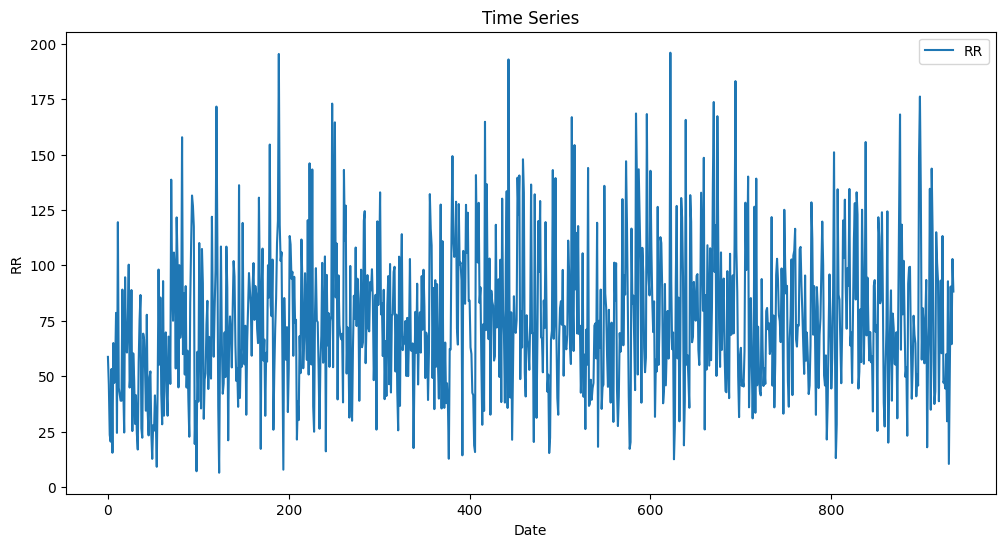

(-6.621271517621477,
 6.028572414385089e-09,
 11,
 924,
 {'1%': -3.437446926086526,
  '5%': -2.8646730402041443,
  '10%': -2.568438225155076},
 8977.91697796861)

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(rr_mean_df['VALEUR'], label='RR')
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('RR')
plt.legend()
plt.show()

adf_rr_test_result = adfuller(rr_mean_df['VALEUR'])

adf_rr_test_result

In [22]:
multiplicative_decomposition_rr = seasonal_decompose(rr_mean['VALEUR'], model='multiplicative', period=12)

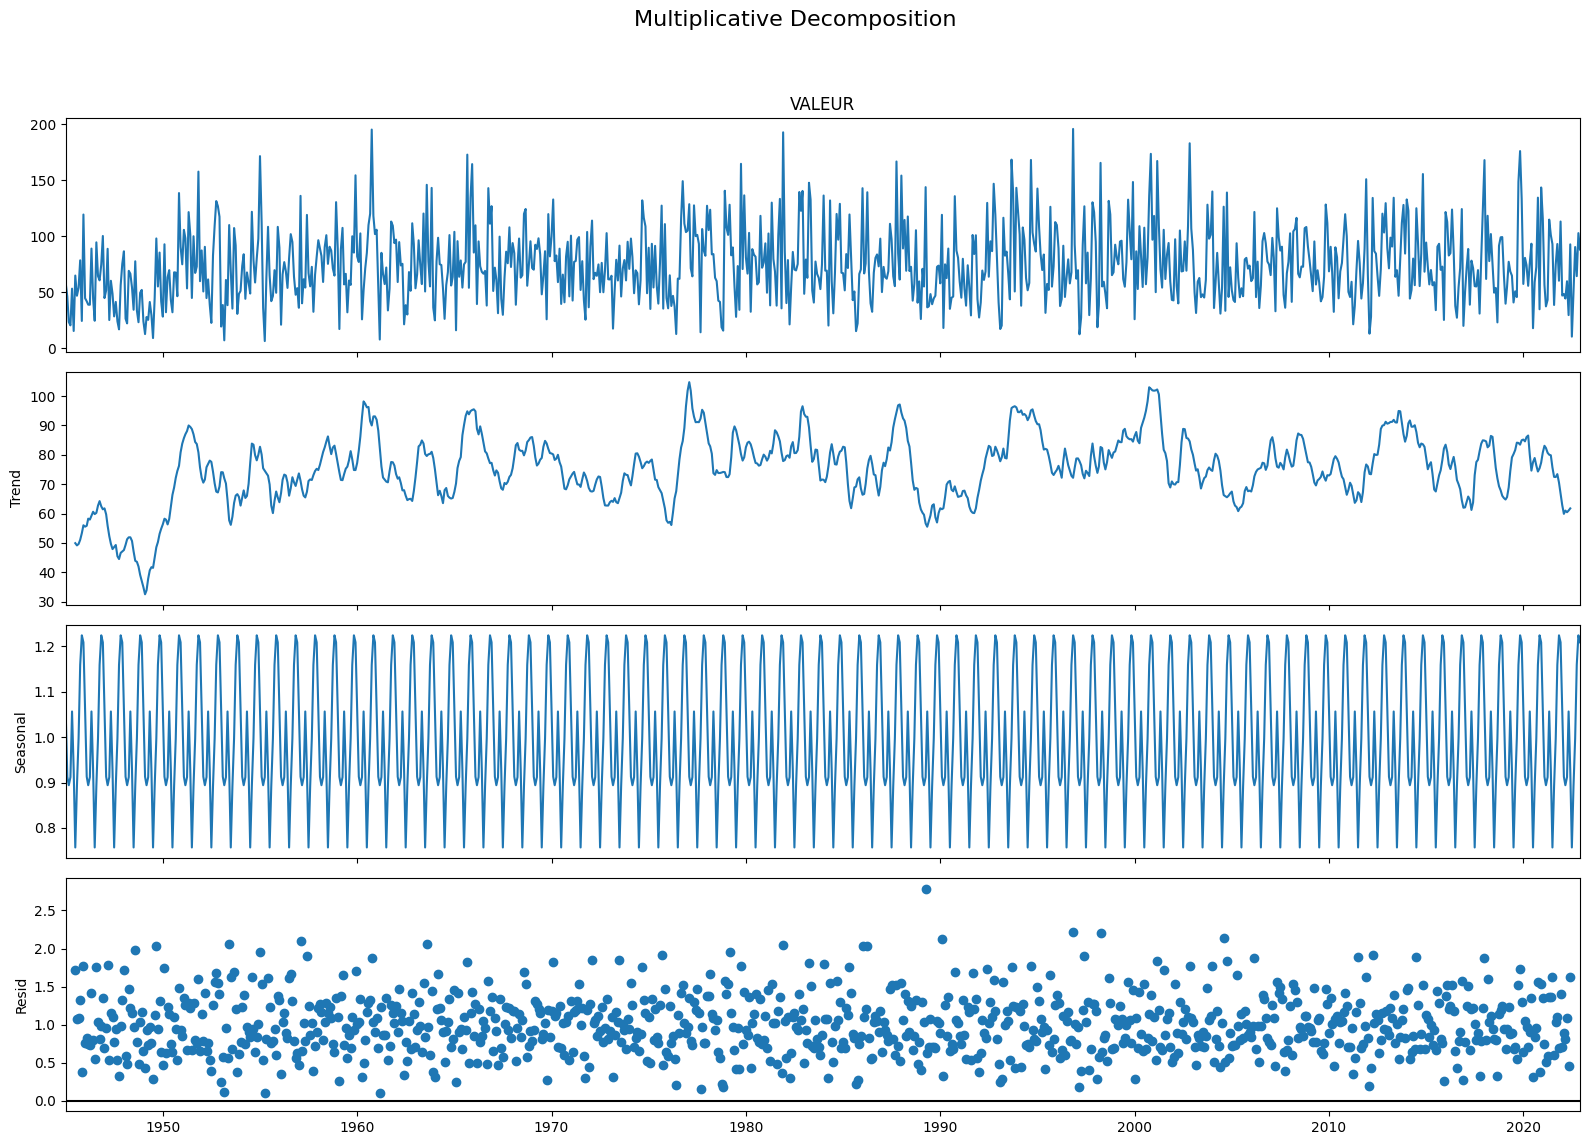

In [23]:
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition_rr.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [24]:
data_length = len(rr_mean_df)
data_length

# Définir les indices pour diviser les données - 80% pour l'entraînement, 20% pour le test
train_size = int(data_length * 0.98)
test_size = data_length - train_size

# Préparer les séries d'apprentissage et de test
train_df = rr_mean_df.iloc[:train_size]
test_df = rr_mean_df.iloc[train_size:]

# Sélectionner la colonne 'RR' pour l'analyse
X_train = train_df['VALEUR']
X_test = test_df['VALEUR']

train_size, test_size

(917, 19)

c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


31.584974358108326


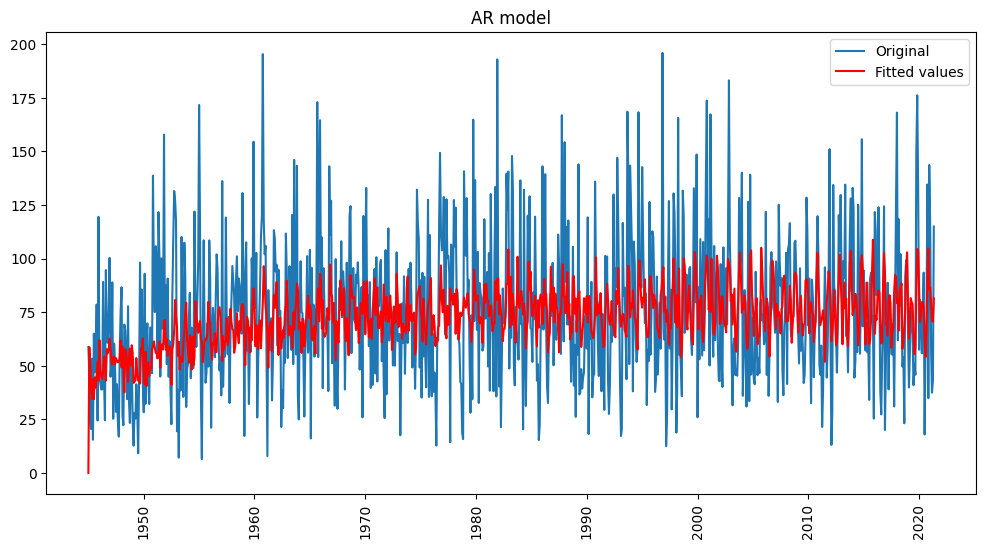

In [25]:
# Modèle ARIMA
model_ARIMA = ARIMA(X_train, order=(12, 1, 12))  
results_ARIMA = model_ARIMA.fit()

# Calculer le RMSE pour le modèle AR
rmse = sqrt(mean_squared_error(X_train, results_ARIMA.fittedvalues))
print(rmse)

plt.figure(figsize=(12, 6))
plt.plot(train_df['YYYYMM'], train_df['VALEUR'], label='Original')
plt.plot(train_df['YYYYMM'], results_ARIMA.fittedvalues, color='red', label='Fitted values')
plt.xticks(rotation=90)
plt.title('AR model')
plt.legend()
plt.show()

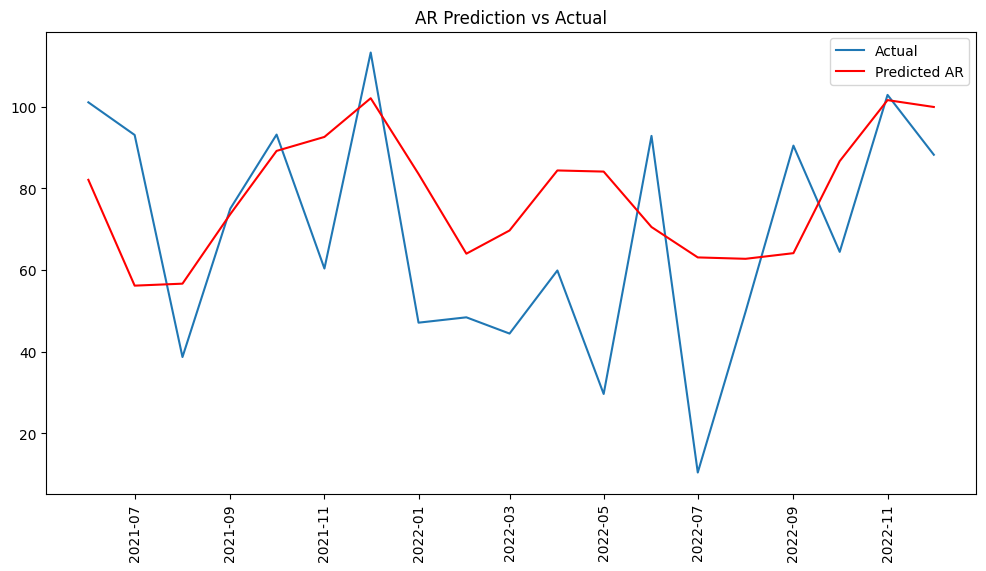

In [26]:
# Prédictions avec le modèle AR
predictions_AR = results_ARIMA.forecast(steps=test_size)

# Préparer la visualisation des prédictions AR vs valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(test_df['YYYYMM'], X_test, label='Actual')
plt.plot(test_df['YYYYMM'], predictions_AR, color='red', label='Predicted AR')
plt.xticks(rotation=90)
plt.title('AR Prediction vs Actual')
plt.legend()
plt.show()

## Prédiction de la moyenne mensuelle de la température minimale sous abri (en °C et 1/10)

In [27]:
dossier = './data/TN/'
dfs = []

for fichier in os.listdir(dossier):
    if fichier.endswith('.csv'):
        chemin_fichier = os.path.join(dossier, fichier)
        df = pd.read_csv(chemin_fichier, delimiter=';', skiprows=12)
        dfs.append(df)

data_TN = pd.concat(dfs, ignore_index=True)
data_TN = data_TN.head(2000)
data_TN.head()
# data_TN.to_csv('./TN.csv', index=False)
data_TN['YYYYMM'] = pd.to_datetime(data_TN['YYYYMM'], format='%Y%m')
pd.DataFrame(data_TN.groupby(['YYYYMM']).mean())

,VALEUR,Q_HOM
YYYYMM,,
1951-01-01,-1.40,1.0
1951-02-01,-1.10,1.0
1951-03-01,0.30,1.0
1951-04-01,4.20,1.0
1951-05-01,7.00,1.0
...,...,...
2022-08-01,14.35,0.5
2022-09-01,10.35,0.5
2022-10-01,10.90,0.5


In [28]:
tn_mean = data_TN.groupby('YYYYMM').mean()
tn_mean_df = pd.DataFrame(tn_mean)
tn_mean_df = tn_mean_df.reset_index()

In [29]:
additive_decomposition_tn = seasonal_decompose(tn_mean_df['VALEUR'], model='additive', period=12)

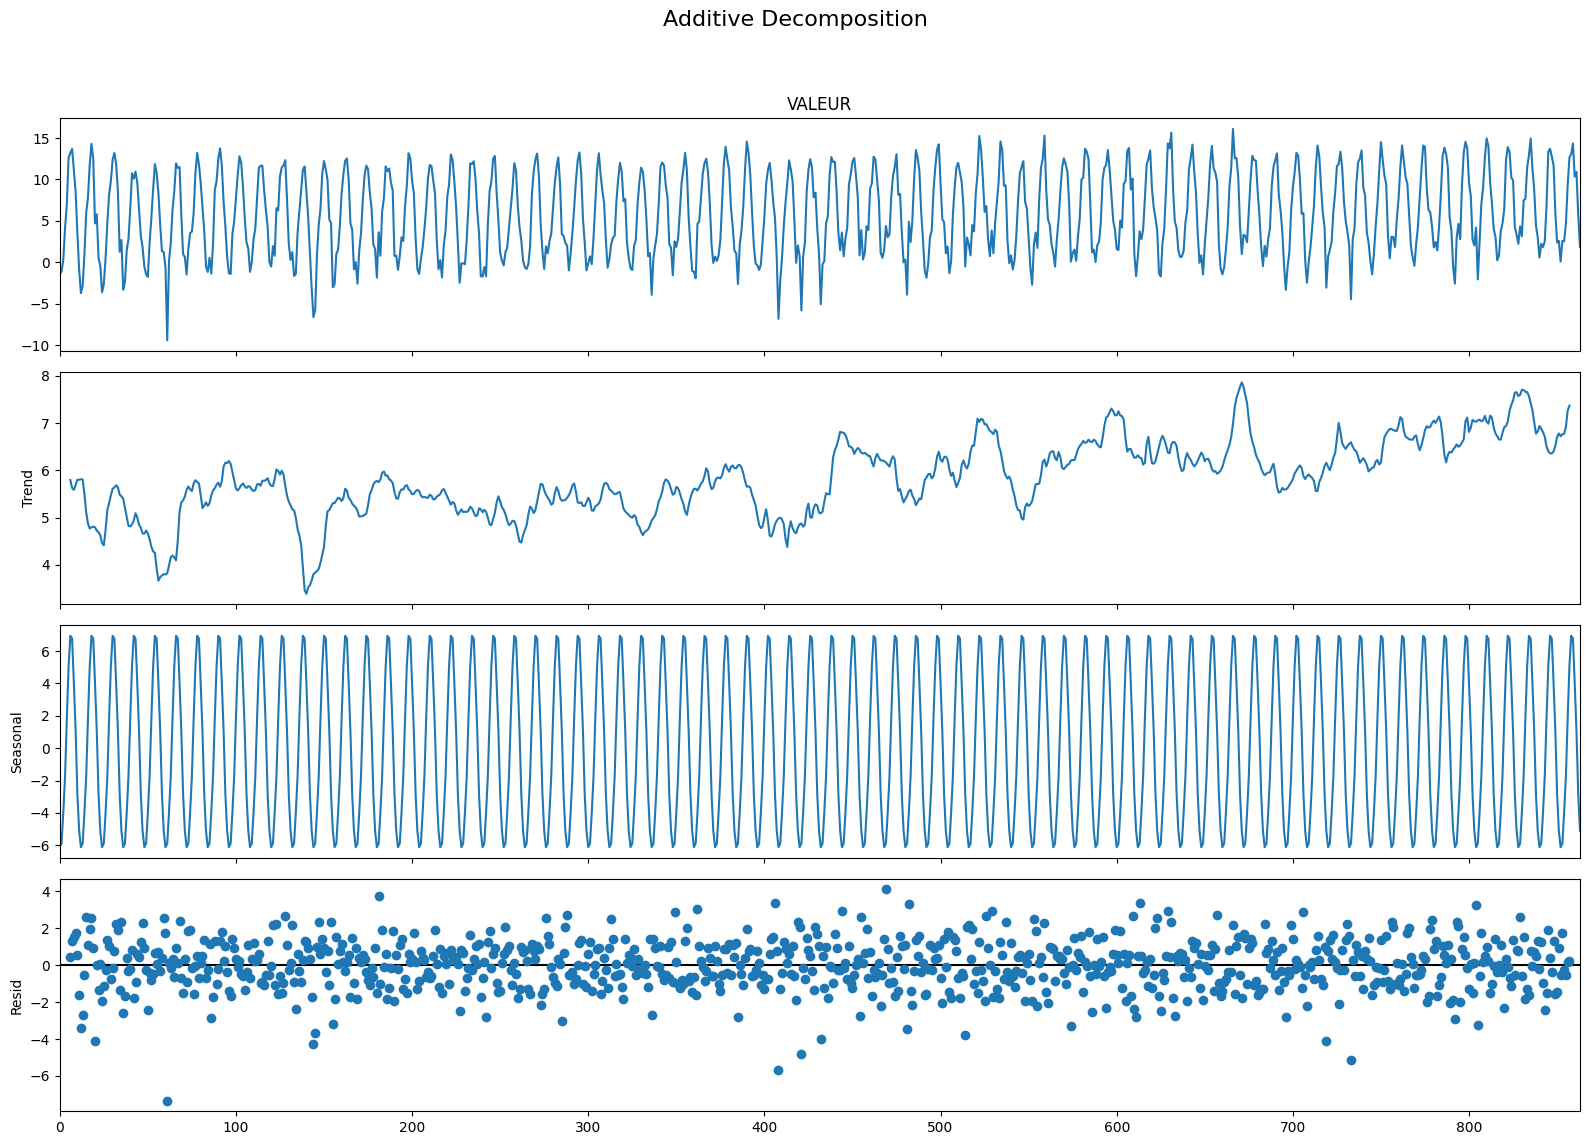

In [30]:
plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition_tn.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [31]:
data_length = len(tn_mean_df)
data_length

# Définir les indices pour diviser les données - 80% pour l'entraînement, 20% pour le test
train_size = int(data_length * 0.98)
test_size = data_length - train_size

# Préparer les séries d'apprentissage et de test
train_df = rr_mean_df.iloc[:train_size]
test_df = rr_mean_df.iloc[train_size:]

# Sélectionner la colonne 'RR' pour l'analyse
X_train = train_df['VALEUR']
X_test = test_df['VALEUR']

train_size, test_size

(846, 18)

c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


31.889454951989546


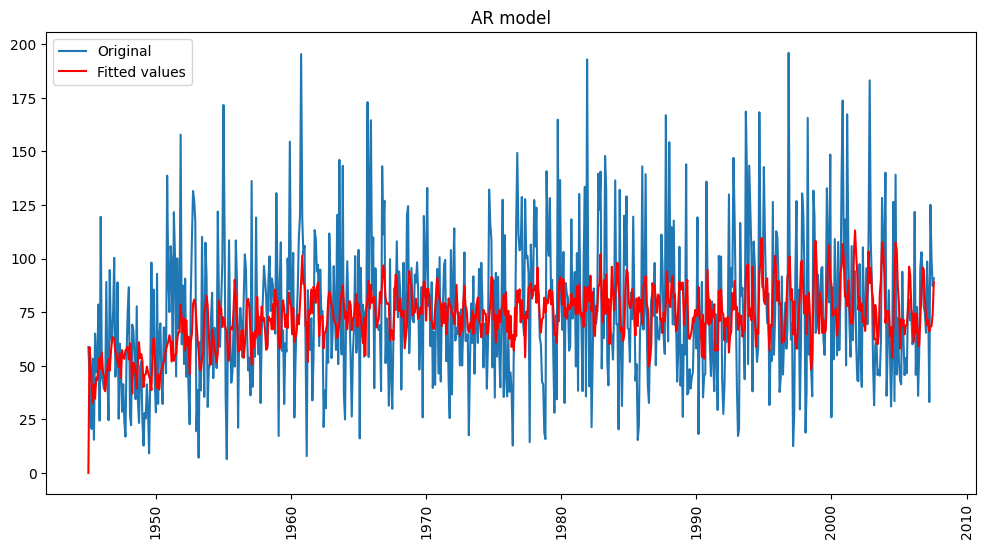

In [46]:
# Modèle ARIMA
model_ARIMA = ARIMA(X_train, order=(12, 1, 24))  
results_ARIMA = model_ARIMA.fit()

# Calculer le RMSE pour le modèle AR
rmse = sqrt(mean_squared_error(X_train, results_ARIMA.fittedvalues))
print(rmse)

plt.figure(figsize=(12, 6))
plt.plot(train_df['YYYYMM'], train_df['VALEUR'], label='Original')
plt.plot(train_df['YYYYMM'], results_ARIMA.fittedvalues, color='red', label='Fitted values')
plt.xticks(rotation=90)
plt.title('AR model')
plt.legend()
plt.show()

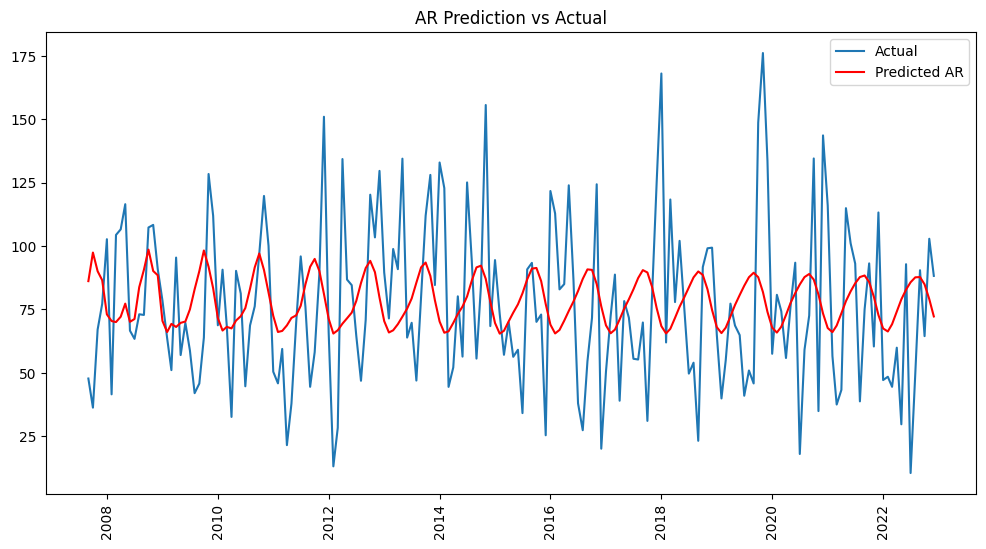

In [48]:
# Prédictions avec le modèle AR
predictions_AR = results_ARIMA.forecast(steps=184)

# Préparer la visualisation des prédictions AR vs valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(test_df['YYYYMM'], X_test, label='Actual')
plt.plot(test_df['YYYYMM'], predictions_AR, color='red', label='Predicted AR')
plt.xticks(rotation=90)
plt.title('AR Prediction vs Actual')
plt.legend()
plt.show()

In [ ]:
predictions_AR.shape

(16,)

## Prédiction de la moyenne mensuelle de la température maximale sous abri (en °C et 1/10)

In [35]:
dossier = './data/TX/'
dfs = []

for fichier in os.listdir(dossier):
    if fichier.endswith('.csv'):
        chemin_fichier = os.path.join(dossier, fichier)
        df = pd.read_csv(chemin_fichier, delimiter=';', skiprows=12)
        dfs.append(df)

data_TX = pd.concat(dfs, ignore_index=True)
data_TX = data_TX.head(2000)
# data_TX.to_csv('./TX.csv', index=False)
data_TX['YYYYMM'] = pd.to_datetime(data_TX['YYYYMM'], format='%Y%m')
pd.DataFrame(data_TX.groupby(['YYYYMM']).mean())

,VALEUR,Q_HOM
YYYYMM,,
1959-01-01,4.933333,1.0
1959-02-01,9.800000,1.0
1959-03-01,12.266667,1.0
1959-04-01,14.266667,1.0
1959-05-01,19.100000,1.0
...,...,...
2022-08-01,28.400000,0.5
2022-09-01,21.300000,0.5
2022-10-01,21.450000,0.5


In [36]:
tx_mean = data_TX.groupby('YYYYMM').mean()
tx_mean_df = pd.DataFrame(tx_mean)
tx_mean_df = tx_mean_df.reset_index()

In [37]:
additive_decomposition_tx = seasonal_decompose(tx_mean_df['VALEUR'], model='additive', period=12)

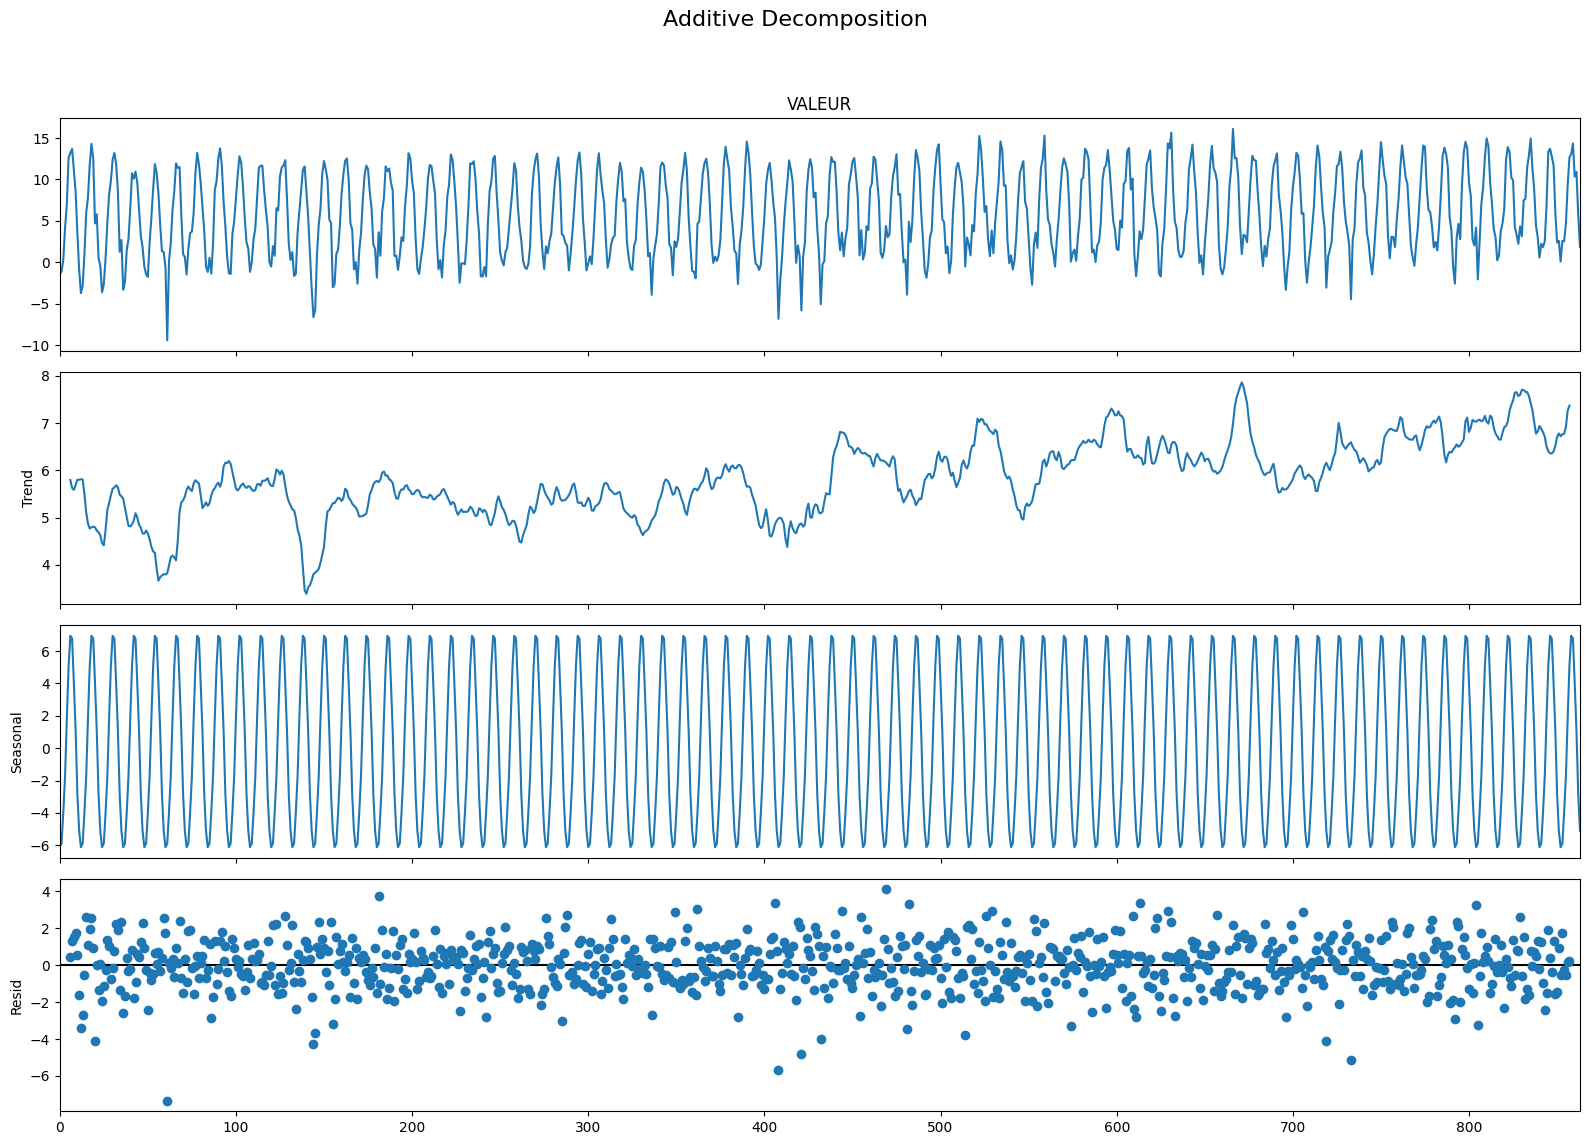

In [38]:
plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition_tn.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [39]:
data_length = len(tx_mean_df)
data_length

# Définir les indices pour diviser les données - 80% pour l'entraînement, 20% pour le test
train_size = int(data_length * 0.98)
test_size = data_length - train_size

# Préparer les séries d'apprentissage et de test
train_df = rr_mean_df.iloc[:train_size]
test_df = rr_mean_df.iloc[train_size:]

# Sélectionner la colonne 'RR' pour l'analyse
X_train = train_df['VALEUR']
X_test = test_df['VALEUR']

train_size, test_size

(752, 16)

c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


31.889454951989546


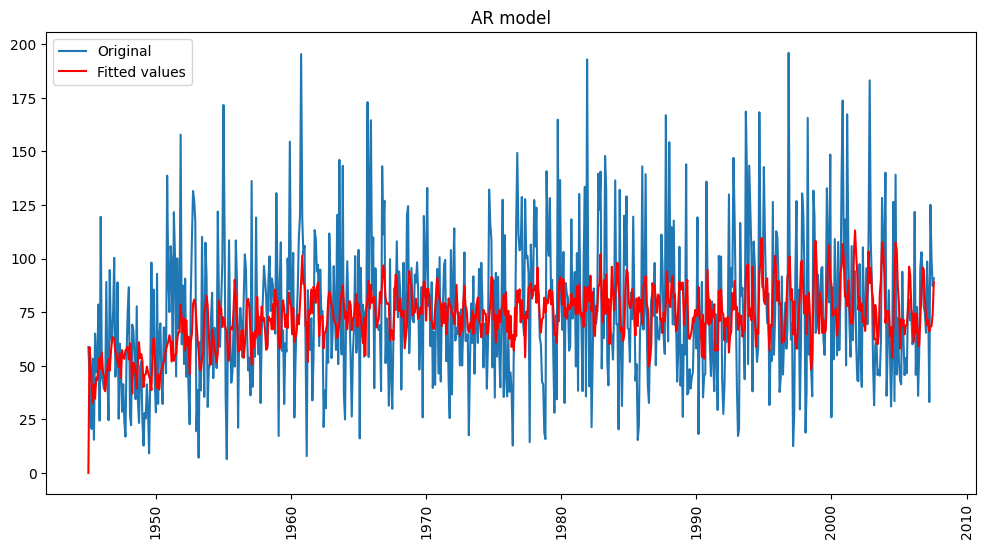

In [40]:
# Modèle ARIMA
model_ARIMA = ARIMA(X_train, order=(12, 1, 24))  
results_ARIMA = model_ARIMA.fit()

# Calculer le RMSE pour le modèle AR
rmse = sqrt(mean_squared_error(X_train, results_ARIMA.fittedvalues))
print(rmse)

plt.figure(figsize=(12, 6))
plt.plot(train_df['YYYYMM'], train_df['VALEUR'], label='Original')
plt.plot(train_df['YYYYMM'], results_ARIMA.fittedvalues, color='red', label='Fitted values')
plt.xticks(rotation=90)
plt.title('AR model')
plt.legend()
plt.show()

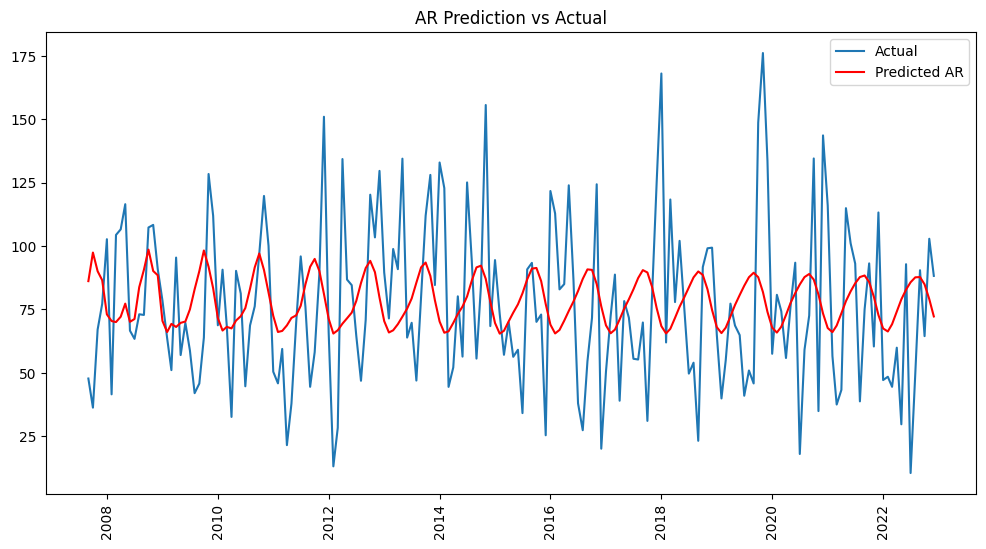

In [43]:
# Prédictions avec le modèle AR
predictions_AR = results_ARIMA.forecast(steps=184)

# Préparer la visualisation des prédictions AR vs valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(test_df['YYYYMM'], X_test, label='Actual')
plt.plot(test_df['YYYYMM'], predictions_AR, color='red', label='Predicted AR')
plt.xticks(rotation=90)
plt.title('AR Prediction vs Actual')
plt.legend()
plt.show()